In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
import pandas as pd
from celmech.poincare import Poincare
import scipy.optimize as opt
%matplotlib inline

In [2]:
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from celmech.disturbing_function import laplace_b as b
from scipy.optimize import fsolve

In [3]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [8]:
def sim(alpha, mass, ecc, pom):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    m1, m3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=m1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=m3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    Nout = 1000
    times = np.linspace(0,5*Tsec, Nout)
    
    ecc1, ecc2, ecc3, e21, e32 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)  
            
            ecc1[i] = e1
            ecc2[i] = e2
            ecc3[i] = e3
            
            e21[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
            e32[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
                       
        except rebound.Collision:
            break
    
    fig, axarr = plt.subplots(nrows=5, figsize=(12,14))
    axarr[0].plot(times, ecc1, 'k.')
    axarr[0].set_ylabel(r"$e_{1}$")
    
    axarr[1].plot(times, ecc2, 'k.')
    axarr[1].set_ylabel(r"$e_{2}$")
    
    axarr[2].plot(times, ecc3, 'k.')
    axarr[2].set_ylabel(r"$e_{3}$")
    
    axarr[3].plot(times, e21, 'k.')
    axarr[3].set_ylabel(r"$e_{21}$")
    
    axarr[4].plot(times, e32, 'k.')
    axarr[4].set_ylabel(r"$e_{32}$")

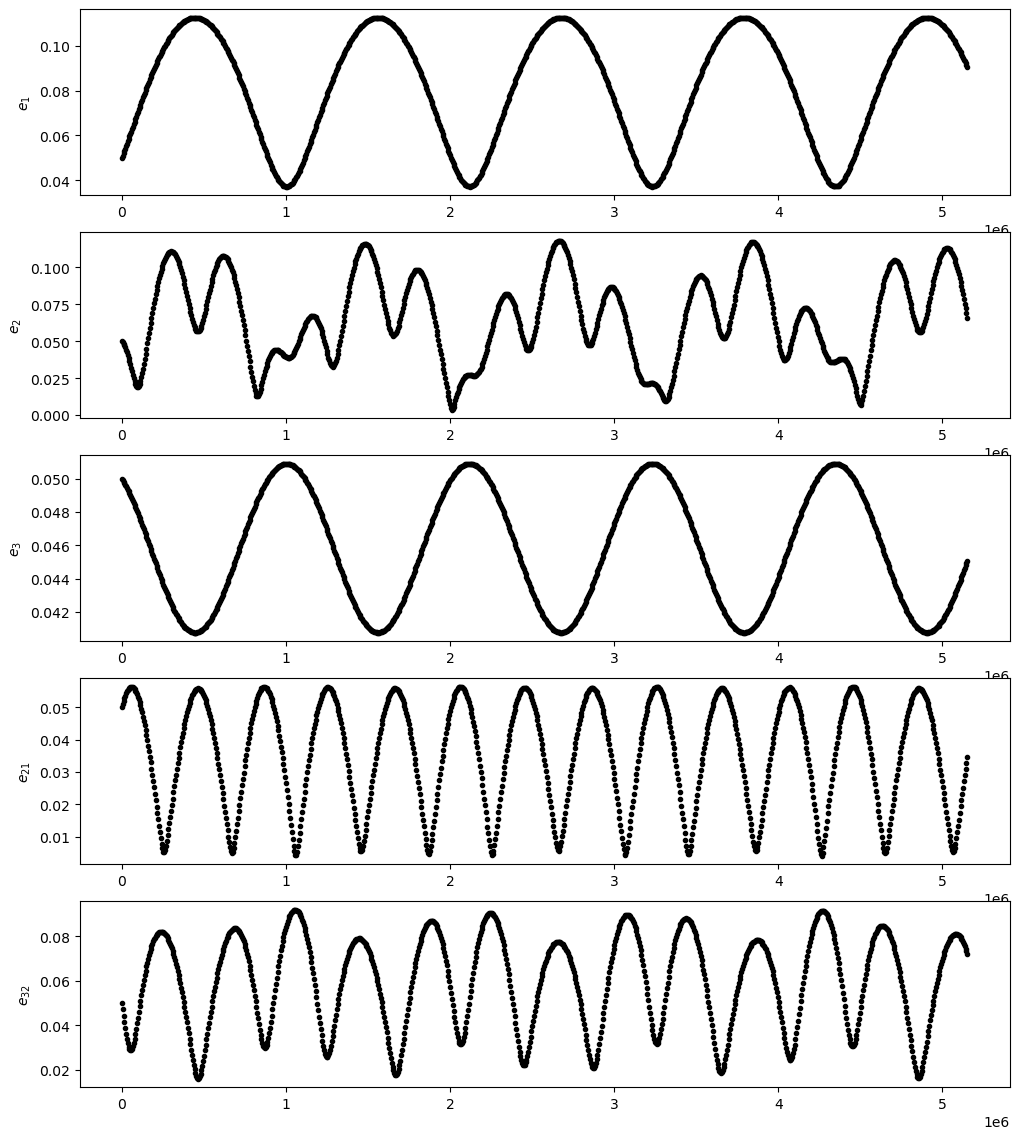

In [15]:
alpha = 0.9,0.75
mass = 1e-7,10e-7
ecc = 0.05, 0.05, 0.05
pomega = -np.pi/3, 0, np.pi/3
sim(alpha, mass, ecc, pomega)

## first-order resonance chart

<div>
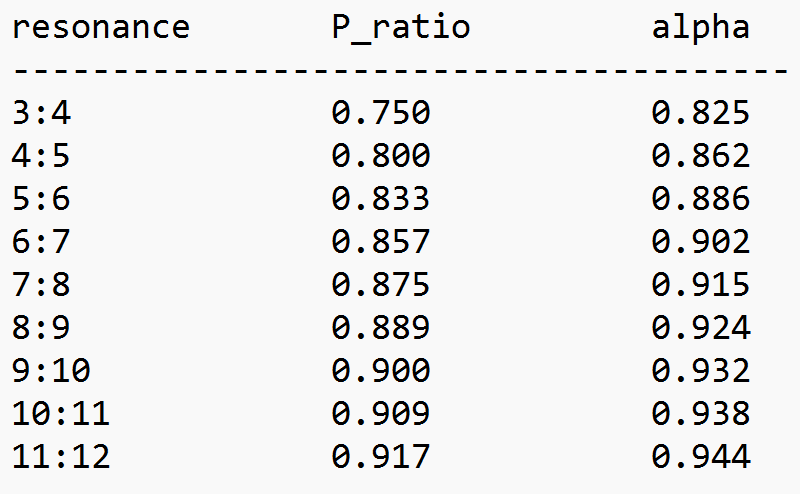
</div>